In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable

### Load Data and Visualise it

In [24]:
data = pd.read_csv("data/dataset_1.csv", sep=",")
data.head()

,ts,acc,pos
0,0.000000,-0.003530,0.000000
1,0.005001,-0.000897,0.000033
2,0.010002,-0.000376,0.000066
3,0.015003,-0.001351,0.000098
4,0.020004,-0.007139,0.000131


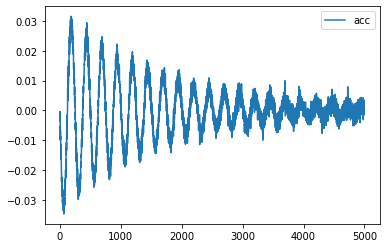

In [25]:
data.plot(y="acc")

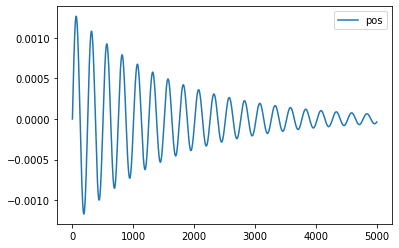

In [26]:
data.plot(y="pos")

In [27]:
data.shape

(4999, 3)

In [28]:
train_len = int(0.8 * data.shape[0])
test_len = data.shape[0] - train_len
print(train_len)
print(test_len)

3999
1000


In [29]:
# Getting Input and Output Data
data_x_ = data[["acc"]].values
data_y_ = data[["pos"]].values

In [30]:
def sliding_windows(data_x, data_y, window_size):
    x = []
    y = []
    assert data_x.shape[0] == data_y.shape[0]
    for i in range(len(data_y)-window_size-1):
        _x = data_x[i:(i+window_size)]
        _y = data_y[i+window_size]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

In [31]:
window_size = 3

data_x, data_y = sliding_windows(data_x_, data_y_, window_size)
print(" Data X Shape:", data_x.shape)
print(" Data Y Shape:", data_y.shape)

 Data X Shape: (4995, 3, 1)
 Data Y Shape: (4995, 1)


In [32]:
# Changing this data into tensors
data_X = torch.Tensor(data_x)
data_Y = torch.Tensor(data_y)
print(" Data X Shape:", data_X.shape)
print(" Data Y Shape:", data_Y.shape)

 Data X Shape: torch.Size([4995, 3, 1])
 Data Y Shape: torch.Size([4995, 1])


##### Train - Test Split

In [33]:
data_x_train = Variable(torch.Tensor(data_x[:train_len]))
data_y_train = Variable(torch.Tensor(data_y[:train_len]))

data_x_test = Variable(torch.Tensor(data_x[train_len:]))
data_y_test = Variable(torch.Tensor(data_y[train_len:]))

print("Train tesnsor shape", data_x_train.shape)
print("Test tesnsor shape", data_x_test.shape)

Train tesnsor shape torch.Size([3999, 3, 1])
Test tesnsor shape torch.Size([996, 3, 1])


### Defining the LSTM Model

In [34]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size

        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = torch.zeros(
            self.num_layers, x.size(0), self.hidden_size)
        
        c_0 = torch.zeros(
            self.num_layers, x.size(0), self.hidden_size)
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [45]:
# Model Parameters
num_epochs = 2000
learning_rate = 0.001

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

In [46]:
lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

In [47]:
data_x_train.shape

torch.Size([3999, 3, 1])

In [48]:
# Train the model
loss_epoch = []
for epoch in range(num_epochs):
    outputs = lstm(data_x_train)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, data_y_train)
    
    # saving loss in each epoch
    loss_epoch.append(loss.detach().numpy())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 1000 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.03327
Epoch: 1000, loss: 0.00000


In [49]:
print(" Data X Shape:", data_X.shape)
print(" Data Y Shape:", data_Y.shape)

 Data X Shape: torch.Size([4995, 3, 1])
 Data Y Shape: torch.Size([4995, 1])


In [50]:
lstm.eval()
train_predict = lstm(data_X)

data_predict = train_predict.data.numpy()
dataY_plot = data_Y.data.numpy()

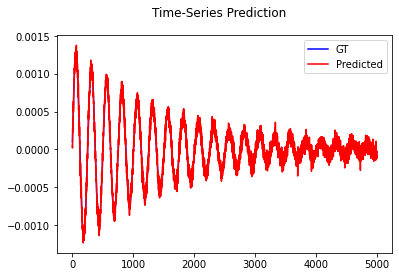

In [51]:
plt.plot(dataY_plot, label="GT", color="b")
plt.plot(data_predict, label="Predicted", color="r")
plt.suptitle('Time-Series Prediction')
plt.legend()
plt.savefig("output.png", dpi=900)
plt.show()

Text(0.5, 1.0, 'Loss vs Epoch')

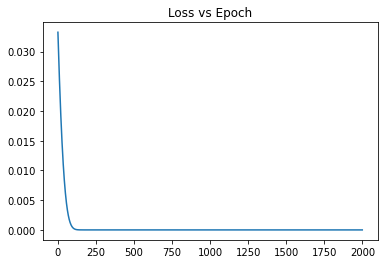

In [52]:
plt.plot(loss_epoch)
plt.title("Loss vs Epoch")

In [43]:
from sklearn.metrics import mean_squared_error

In [44]:
mean_squared_error(dataY_plot, data_predict)

0.0007315397